# The Final Compression Project – Compressão e Codificação de Dados

```
Štěpán Pešout
Universidade de Évora
15/01/2022
```

## Brief description

This project works with images and combines lossy and lossless compression techniques.

At first, the image is represented as a three-dimensional integer array, from which three two-dimensional arrays representing **each of the color layers are extracted**.

Then, two coefficients and an intercept are obtained using **linear regression**, so that the color values of the blue layer can be computed using only the red and green color layers.

In the red and green layers, **similar values are then represented by their median**. When iterating over the arrays, the **frequencies of occurrence** of each color shade in both layers are calculated.

The 256 color shades, for which the frequencies of occurrence are therefore known, serve as the "alphabet" for the **Huffman tree construction**. This makes it possible to create a dictionary and the original data is translated into binary code, then into an array of bytes, then into characters and **stored in a file**. The necessary information needed for decompression (color frequencies, regression coefficients, etc.) is also stored.

This work also includes a **decompression algorithm** that allows the image to be reconstructed. Clearly, due to the use of lossy compression techniques, the exact original image can no longer be restored.

## Imports

In [2]:
import PIL.Image as pimg
import numpy as np
import sklearn.linear_model as lm
import statistics as st
import pandas as pd

## Function to create a image from the three separate layers
- `red` – red color layer
- `green` – green color layer
- `blue` – blue color layer
- `show` determines if is the image shown or just returned
- function returns image data as PIL.Image

In [3]:
def buildImage(red, green, blue, show = True):
    
    data = np.dstack((red, green, blue))
    img = pimg.fromarray(np.uint8(np.array(data)))
    
    if (show):
        img.show()
        
    return img

## Regression functions

### Function to count regression coefficients

- `color1` (independent) is usually the red layer
- `color2` (independent) is usually the green layer
- `dependent` is usually the blue layer
- function returns two coefficients and an intercept for computing the dependent layer in the future

In [4]:
def colorRegression (color1, color2, dependent):
    
    regr = lm.LinearRegression()
    
    independents = np.reshape(np.dstack(
        (color1, color2)),
        (len(color1) * len(color1[0]), 2
    ))
    regr.fit(independents, dependent.flatten())
    
    return [regr.coef_[0], regr.coef_[1], regr.intercept_]

### Function to compute color values of a layer

- `color1` – first color layer (usually the red one)
- `color2` – second color layer )(usually the green one)
- `color1_cf` is the coefficient for multiplying color1 values
- `color2_cf` is the coefficient for multiplying color2 values
- `intercept` is the value to add after the multiplication

- function returns computed values for the third layer (usually blue)

In [5]:
def computeLayer(color1, color2, color1_cf, color2_cf, intercept):
    
    raw = color1 * color1_cf + color2 * color2_cf + intercept
    
    # Round float values and eliminate negatives
    return np.clip(np.around(raw).astype(int), 0, 1000)

## Function to replace similar values by their median

- `layer` is the color layer
- `max_error` is the value which determines maximal difference of the layer values to be considered as the same
- `fill_number` is the value to be inserted between two medians
- function returns the modificated layer and the frequencies of the color values

In [6]:
def medianize(layer, max_error, fill_number = None):
    
    error = 0
    anchor = layer[0][0] # The first layer value
    queue = []
    layer_flat = layer.flatten()
    layer_len = len(layer_flat)
    result = [] * layer_len
    frequencies = [0] * 256 # frequencies[x] is the frequency of x in the layer

    for idx, i in enumerate(layer_flat):
        error = abs(int(i) - int(anchor))

        # If is the difference too big
        if (error > max_error or idx == layer_len - 1): 
    
            # True only for the last cycle run
            if (idx == layer_len - 1): 
                queue.append(int(i))
                
            anchor = i 
            
            # Median from the similar values
            median = round(st.median(queue)) 
            
            frequencies[median] += 1
            result.append(median)
            
            # Fill the result layer
            for m in range(len(queue) - 1):
                
                # Previously declared value or median
                if (fill_number == None):
                    
                    result.append(median)
                    frequencies[median] += 1
                    
                else:
                    
                    result.append(fill_number)
                    frequencies[fill_number] += 1
                
            queue = []

        queue.append(int(i))
    
    return [
        # Layer as the original-shaped 2D array
        np.uint8(np.array(result)).reshape(
            len(layer),
            len(layer[0])
        ),
        # Frequencies of the color values
        np.array(frequencies)
    ]

## Functions to handle Huffman tree nodes

### Function to create the mode

- every node is represented by a list
- `left` and `right` are the child nodes
- `number` is the alphabet symbol
- `frequency` is the frequency of the number (symbol)

In [7]:
def createNode (left, right, number, frequency):
    
    return [left, right, number, frequency, ""]

### Functions to get and set node properties

In [8]:
def getLeft(node):
    
    return node[0]

In [9]:
def getRight(node):
    
    return node[1]

In [10]:
def getNumber(node):
    
    return node[2]

In [11]:
def getFrequency(node):
    
    return node[3]

In [12]:
def getCode(node):
    
    return node[4]

In [13]:
def setCode(node, code):
    
    node[4] = code
    return node

### Function to create a list of nodes

- this function creates and returns a list with nodes (it converts the numbers and frequencies into the tree nodes)
- child nodes are not present yet
- `frequencies` is the list of frequencies of numbers

In [14]:
def createNodes(frequencies):
    
    nodes = []
    
    for f in range(len(frequencies)):
        
        # If the frequency is zero
        if (frequencies[f] == 0):
            continue
            
        nodes.append(createNode(None, None, f, frequencies[f]))
    
    return nodes

### Function to get two tree nodes with the least frequency (the least probability of observing)

- `nodes` is the node array

In [15]:
def getRarestNodes(nodes):
    
    # Sort nodes ascendingly by their frequency
    nodes = sorted(nodes, key = lambda n: getFrequency(n))
    
    return [nodes[0], nodes[1]]

## Function to build the Huffman tree

- this function creates the correct hierarchy (parent – children) of nodes according to the frequency
- `frequencies` is the list of frequencies of numbers
- function returns the root node of the tree

In [16]:
def buildTree(frequencies):
    
    nodes = createNodes(frequencies)
    
    # While the nodes are not on their proper places
    while len(nodes) > 1:

        left, right = getRarestNodes(nodes)

        # Assign code to the nodes
        left = setCode(left, 0)
        right = setCode(right, 1)

        # Create the parent node for the nodes with the least frequencies
        node = createNode(
            left, 
            right, 
            getNumber(left) + getNumber(right), # Numbers have the role of alphabet sybmols, so they are strings 
            getFrequency(left) + getFrequency(right) # Sum of the both frequencies
        )

        # Nodes are copied to the proper place, so remove the old ones
        nodes.remove(left)
        nodes.remove(right)
        
        # Append the newly created node to the node array
        nodes.append(node)
        
    # Return the root node    
    return nodes[0]

## Function to read the Huffman tree and create a dictionary from it

- the function uses recursion to read the tree
- `node` is the root node
- `code_prefix` is already retrieved code (when the function calls itself)
- `nodes` is a list of already retrieved nodes to build the dictionary
- function returns the dictionary or it's fragment

In [17]:
def getDictionary(node, code_prefix = "", nodes = None):
     
    previous_nodes = nodes
    
    # This is typically true when calling the function from outside
    if (nodes == None):
        nodes = []
    
    # Merge new code with the previous part
    code = code_prefix + str(getCode(node))
    
    left_node = getLeft(node)
    right_node = getRight(node)
    
    # If left node exists
    if(left_node):
        
        # Get what is on the left and append it to the code
        left_nodes = getDictionary(left_node, code, nodes)
        
        if (left_nodes):
            nodes.append(left_nodes)

    # If right node exists
    if(right_node):
        
        # Get what is on the right and append it to the code
        right_nodes = getDictionary(right_node, code, nodes)
        
        if (right_nodes):
            nodes.append(right_nodes)
            
    # If there are no prevous nodes and the dictionary is done        
    if (previous_nodes == None):
        return dict(np.array(
                sorted(nodes, key = lambda n: int(n[0]))
        ))
    
    # If this node has no children
    if(not left_node and not right_node):
        return [getNumber(node), code]
            

## Function to get the binary from the color layer

- the function translates the color values to binary according to the dictionary from Huffman tree
- after that, the array is joined to a string, packed to chunks of the size 8, translated into decimal integers and the result is returned
- `layer` is the color layer
- `frequencies` is the list of frequencies

In [18]:
def layerToBinary(layer, frequencies):
    
    # Build the Huffman tree and get the dictionary from it
    tree = buildTree(frequencies)
    dictionary = getDictionary(tree)
    
    # Translate using the dictionary, join to the string, pack to the chunks, translate to decimal
    return np.packbits(np.array(list("".join(
        np.vectorize(dictionary.get)(layer.astype(str))
        .flatten()
        .tolist()
    ))).astype(int))

## Function to save binary to a file

- `name` is the file name
- `binary` is the array of the values to save

In [19]:
def saveCompressed(name, binary):
    
    # Data is saved as a .small file
    file = open(name + ".small", "wb")
    file.write(bytearray(binary))
    file.close()

## Function to save a recipe to a file

- recipe contains important information to decompress the file
- `frequencies` is the list of frequencies
- `width` of the original image
- `height` of the original image
- `red_regr_coefficient` is a number for multiplying values of the red layer to get the blue one
- `green_regr_coefficient` is a number for multiplying values of the green layer to get the blue one
- `regr_intercept` is a number to add after the multiplication to get the blue layer values

In [20]:
def saveRecipe(frequencies, width, height, red_regr_coefficient, green_regr_coefficient, regr_intercept):
    
    recipe = np.array([
        ["fq", frequencies],
        ["w", width],
        ["h", height],
        ["rc", red_regr_coefficient],
        ["gc", green_regr_coefficient],
        ["ic", regr_intercept]
    ], dtype = object)

    # The recipe is saved as a .small.npy file
    np.save(IMAGE + ".small", recipe)

## Function to load the compressed file and the recipe

- `name` is the file name
- function returns binary and the recipe array

In [21]:
def loadCompressed(name):
    
    recipe = dict(np.load(IMAGE + ".npy", allow_pickle = True))
    
    img_small = open(IMAGE, "rb")
    
    # Get binary from the compressed file
    binary = np.unpackbits(np.frombuffer(bytearray(img_small.read()), dtype=np.uint8))
    
    return [binary, recipe]

## Function to translate binary accoring to the dictionary

- `binary` is the array of bits
- `dictionary` for the translation

In [22]:
def translateBinary(binary, dictionary):
    
    buffer = ""
    layer = []

    for i in binary:
        buffer += str(i)

        # If the code exists in the dictionary
        if buffer in dictionary:
            layer.append(dictionary[buffer])
            buffer = ""
            
    return layer

## Function to replace zeros by the previous value

- `layer` is the color layer
- `recipe` is the recipe array for decompression
- function returns the modified layer

In [23]:
def forwardFillLayer(layer, recipe):
    
    # Replace zeros by the previous value (median)
    replaced = pd.DataFrame(np.array(layer)).replace(to_replace = "0", method = "ffill")

    # Reshape the array accoring to the image width and height
    return np.array(replaced).flatten().astype(int).reshape(recipe["h"], recipe["w"])

## Compression

In [24]:
# ---------------- SETTINGS ----------------

# Image to compress
IMAGE = "test_images/lenna.png"

# Value which determining maximal difference of the layer values to be considered as the same
# High value means poor quality, but small size of the compressed file and vice versa
MAX_ERROR = 10

# ------------------------------------------

# Get the image and split into layers
img = np.array(pimg.open(IMAGE))
red = img[:,:,0]
green = img[:,:,1]
blue = img[:,:,2]

# Get the regression coefficients and the intercept
red_cf, green_cf, intercept = colorRegression(red, green, blue)

# Replace similar values and get the frequency arrays
red_med, red_freq = medianize(red, MAX_ERROR, 0)
green_med, green_freq = medianize(green, MAX_ERROR, 0)

# Compress the layers using the Huffman algorithm
binary = layerToBinary(
    np.array([red_med, green_med]),
    red_freq + green_freq
)

saveCompressed(IMAGE, binary)
saveRecipe(red_freq + green_freq, len(red[0]), len(red), red_cf, green_cf, intercept)

# Count sizes and its ratio
uncomp_size = (len(red) * len(red[0]) * 3) / 1000
comp_size = len(binary) / 1000
ratio = round((comp_size / uncomp_size) * 100, 2)

print("Uncompressed size: " + str(uncomp_size) + " kilobytes")
print("Compressed size: " + str(comp_size) + " kilobytes (" + str(ratio) + " %)")

Uncompressed size: 786.432 kilobytes
Compressed size: 184.769 kilobytes (23.49 %)


## Decompression

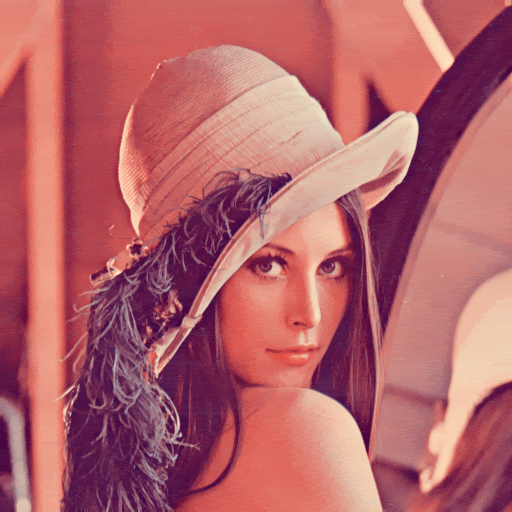

In [25]:
# ---------------- SETTINGS ----------------

# Image to decompress
IMAGE = "test_images/lenna.png.small"

# ------------------------------------------

binary, recipe = loadCompressed(IMAGE)

tree = buildTree(recipe["fq"])
dictionary = getDictionary(tree)

layer = translateBinary(
    binary,
    dict(zip(dictionary.values(), dictionary.keys())) # Reversed dictionary
)

image_size = recipe["w"] * recipe["h"]

red = forwardFillLayer(layer[: image_size], recipe)
green = forwardFillLayer(layer[image_size : 2 * image_size], recipe)

blue_regr = computeLayer(red, green, recipe["rc"], recipe["gc"], recipe["ic"])

buildImage(red, green, blue_regr, False)